# Submisi Time Series Belajar Pengembangan Machine Learning
# Predict total revenue
## Nama : Husni Naufal Zuhdi

## Scoring Criterias

Minimum Criteria
1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.(v)
2. Harus menggunakan LSTM dalam arsitektur model.(v)
3. Validation set sebesar 20% dari total dataset.(v)
4. Model harus menggunakan model sequential.(v)
5. Harus menggunakan Learning Rate pada Optimizer.(v)
6. MAE < 10% skala data.(v)

High Score Criteria
1. Dataset yang digunakan memiliki banyak sampel data.(v)
2. Mengimplementasikan Callback.(v)
3. Membuat plot loss dan akurasi pada saat training dan validation.(v)

4 Star Criteria
1. Semua ketentuan terpenuhi.(v)
2. Dataset memiliki minimal 2000 sampel data.(v)
3. MAE dari model < 10% skala data.(v)

5 Star Criteria
1. Semua ketentuan terpenuhi.(v)
2. Dataset memiliki minimal 10000 sampel data.(x)
3. MAE dari model < 10% skala data.(v)

## Pre Processing

In [1]:
# The process to acces Kaggle API refer to this article
# https://www.kaggle.com/general/74235
# Install kaggle API
! pip install -q kaggle

In [2]:
# Insert my kaggle json key
from google.colab import files
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
# # Download E-Commerce Data
# # https://www.kaggle.com/carrie1/ecommerce-data
! kaggle datasets download -d carrie1/ecommerce-data

 69% 5.00M/7.20M [00:00<00:00, 34.4MB/s]
100% 7.20M/7.20M [00:00<00:00, 35.2MB/s]


In [4]:
# Unzip the dataset
! unzip /content/ecommerce-data.zip

Archive:  /content/ecommerce-data.zip
  inflating: data.csv                


In [5]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM

In [6]:
# Read train csv file
df = pd.read_csv('/content/data.csv', encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [7]:
# Gain insights
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
# Check Null Value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# Pre processing data.csv
# Convert Invoice Date data type into date type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)
df.sort_values('InvoiceDate', inplace=True)

In [10]:
# Combine Quantity * Unit Price to get Total Revenue/purchase
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']

In [11]:
# Agregate Total Revenue/purchase into Total Revenue/day
df = df.groupby('InvoiceDate')[['Quantity', 'TotalRevenue']] \
                .sum().reset_index()
df.head()

,InvoiceDate,Quantity,TotalRevenue
0,2010-01-12 08:26:00,40,139.12
1,2010-01-12 08:28:00,12,22.20
2,2010-01-12 08:34:00,98,348.78
3,2010-01-12 08:35:00,3,17.85
4,2010-01-12 08:45:00,449,855.86


In [12]:
# Transform dataset period to hourly
hourly_sales = df.resample('1H', on = 'InvoiceDate').sum().reset_index()
hourly_sales.head()

,InvoiceDate,Quantity,TotalRevenue
0,2010-01-12 08:00:00,602,1383.81
1,2010-01-12 09:00:00,3259,7324.24
2,2010-01-12 10:00:00,2794,5094.33
3,2010-01-12 11:00:00,2356,4234.16
4,2010-01-12 12:00:00,4161,7422.42


In [13]:
# Check Null Value
hourly_sales.isnull().sum()

InvoiceDate     0
Quantity        0
TotalRevenue    0
dtype: int64

In [14]:
# Check dataset info
hourly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16738 entries, 0 to 16737
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   InvoiceDate   16738 non-null  datetime64[ns]
 1   Quantity      16738 non-null  int64         
 2   TotalRevenue  16738 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 392.4 KB


In [15]:
# Convert dataset into numpy array
dates = hourly_sales['InvoiceDate'].values
quantity = hourly_sales['Quantity'].values
tot_rev  = hourly_sales['TotalRevenue'].values

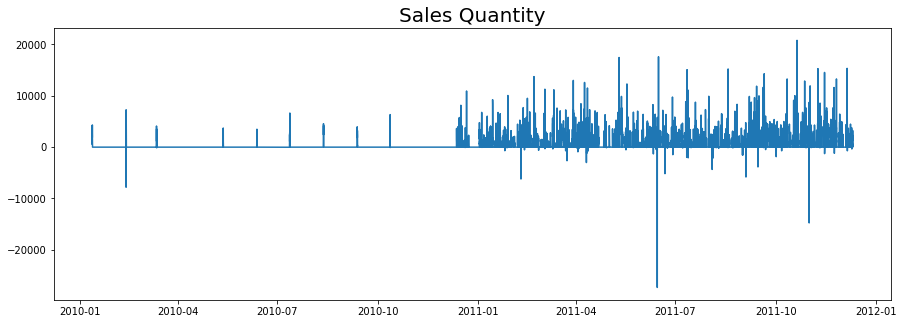

In [16]:
# Plot sales quantity
plt.figure(figsize=(15,5))
plt.plot(dates, quantity)
plt.title('Sales Quantity',fontsize=20);

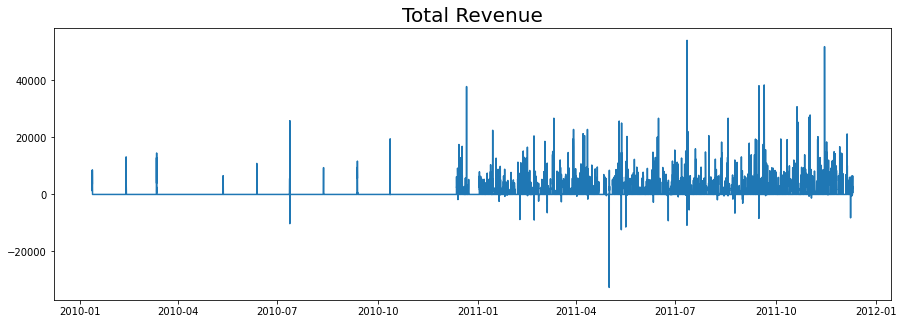

In [17]:
# Plot total revenue
plt.figure(figsize=(15,5))
plt.plot(dates, tot_rev)
plt.title('Total Revenue',fontsize=20);

Because the dataset does not contain much data in the frist year, we need to ampute the first year data an continue use the second year data.

Ampute the data from row 0 to row 8000

24(hour/day)*365(day/year)*1(year) = 8760 or approximate 8000

In [18]:
# Ampute the first 8500 rows
hourly_sales_2 = hourly_sales.iloc[8000:,:]
# Convert dataset into numpy array
dates_2 = hourly_sales_2['InvoiceDate'].values
quantity_2 = hourly_sales_2['Quantity'].values
quantity_2 = tf.cast(quantity_2, dtype='float64')
tot_rev_2  = hourly_sales_2['TotalRevenue'].values
tot_rev_2 = tf.cast(tot_rev_2, dtype='float64')

In [19]:
# Check the dataset info
hourly_sales_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8738 entries, 8000 to 16737
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   InvoiceDate   8738 non-null   datetime64[ns]
 1   Quantity      8738 non-null   int64         
 2   TotalRevenue  8738 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 204.9 KB


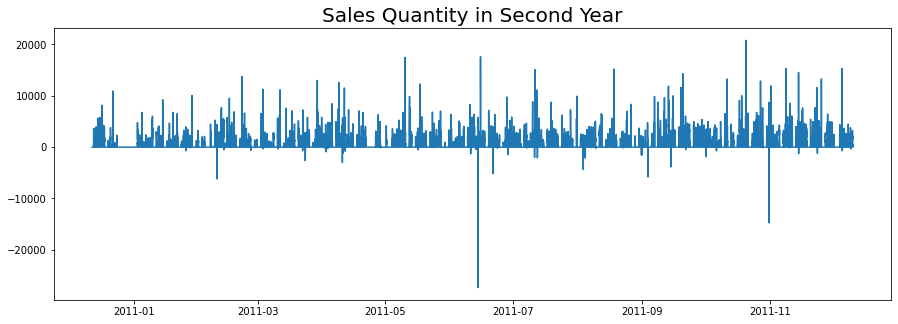

In [20]:
# Plot sales quantity
plt.figure(figsize=(15,5))
plt.plot(dates_2, quantity_2)
plt.title('Sales Quantity in Second Year',fontsize=20);

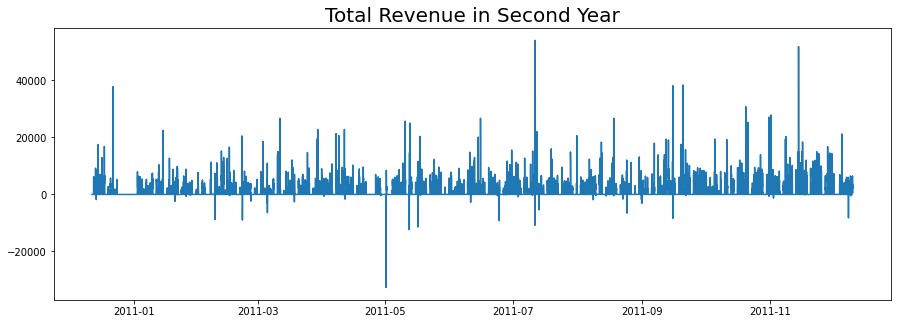

In [21]:
# Plot total revenue
plt.figure(figsize=(15,5))
plt.plot(dates_2, tot_rev_2)
plt.title('Total Revenue in Second Year',fontsize=20);

This is better

In [22]:
# Split data into train and test data
dates_train, dates_test= np.split(dates_2, [int(.80 *len(dates_2))])
quantity_train, quantity_test= np.split(quantity_2, [int(.80 *len(quantity_2))])
tot_rev_train, tot_rev_test= np.split(tot_rev_2, [int(.80 *len(tot_rev_2))])

## Build Machine Learning Model

In [23]:
# Build windowed dataset function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [24]:
# Make Train and Test sets
quantity_train_set = windowed_dataset(quantity_train,
                                      window_size=60,
                                      batch_size=100,
                                      shuffle_buffer=1000)
quantity_test_set = windowed_dataset(quantity_test,
                                      window_size=60,
                                      batch_size=100,
                                      shuffle_buffer=1000)
revenue_train_set = windowed_dataset(tot_rev_train,
                                      window_size=60,
                                      batch_size=100,
                                      shuffle_buffer=1000)
revenue_test_set = windowed_dataset(tot_rev_test,
                                      window_size=60,
                                      batch_size=100,
                                      shuffle_buffer=1000)

In [40]:
# Build our Model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.5)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [26]:
# Check the description of TotalRevenue Column to get max and min values
hourly_sales_2['TotalRevenue'].describe()

count     8738.000000
mean      1065.787889
std       2791.702097
min     -32651.680000
25%          0.000000
50%          0.000000
75%        932.462500
max      54089.630000
Name: TotalRevenue, dtype: float64

In [27]:
# Check the description of Quantity Column to get max and min values
hourly_sales_2['Quantity'].describe()

count     8738.000000
mean       571.012245
std       1462.024151
min     -27322.000000
25%          0.000000
50%          0.000000
75%        492.750000
max      20796.000000
Name: Quantity, dtype: float64

To Calculate Scale of Data we need max value and min value from our dataset

1. TotalRevenue

* (max-min) = 54089.630000 - (-32651.680000) = 86741.31
* (max-min) = ABS(54089.630000) - ABS(-32651.680000) = 21437.95

We will only use TotalRevenue feature because the Quantity feature data scale have negative value (I like to play it safe :) )

Criteraia given by dicoding are we need to get MAE score bellow 10% of Data Scale

* 0.1*86741.31 = 8674.131
* 0.1*21437.95 = 2143.795

In [37]:
# Build Callback Class
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<500):
      if(logs.get('val_mae')<500):
        print("\nModel Mean Absolute Error and Validation Mean Absolute Error bellow 500!")
        self.model.stop_training = True
callbacks = myCallback()

## Train and Test Model

In [41]:
# Test our Machine Learning Model to predict Total Revenue
num_epochs = 200
history = model.fit(revenue_train_set,
                    validation_data=revenue_test_set,
                    epochs=num_epochs,
                    callbacks=[callbacks])

Epoch 1/200
70/70 [==============================] - 22s 259ms/step - loss: 1014.7440 - mae: 1014.9705 - val_loss: 1456.6792 - val_mae: 1456.9487
Epoch 2/200
70/70 [==============================] - 16s 231ms/step - loss: 1014.7103 - mae: 1014.9807 - val_loss: 1456.6460 - val_mae: 1456.9521
Epoch 3/200
70/70 [==============================] - 16s 232ms/step - loss: 1014.6871 - mae: 1014.9891 - val_loss: 1456.6230 - val_mae: 1456.9534
Epoch 4/200
70/70 [==============================] - 16s 232ms/step - loss: 1014.6711 - mae: 1014.9937 - val_loss: 1456.6062 - val_mae: 1456.9520
Epoch 5/200
70/70 [==============================] - 16s 232ms/step - loss: 1014.6591 - mae: 1014.9948 - val_loss: 1456.5925 - val_mae: 1456.9481
Epoch 6/200
70/70 [==============================] - 16s 230ms/step - loss: 1014.6487 - mae: 1014.9918 - val_loss: 1456.5804 - val_mae: 1456.9410
Epoch 7/200
70/70 [==============================] - 16s 230ms/step - loss: 1014.6391 - mae: 1014.9869 - val_loss: 1456.5688

In [42]:
# See model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 60)          14880     
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               96768     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 136,481
Trainable params: 136,481
Non-trainable params: 0
_________________________________________________________________


## Evaluate

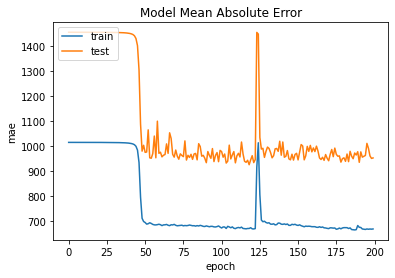

In [43]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

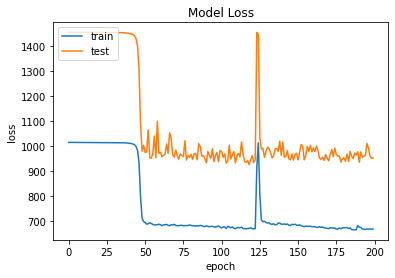

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()